Sigrid's testing markdown

In [2]:
# Import relevant libraries
import os #computer stuff
import numpy as np
import matplotlib.pyplot as plt #plots
import pandas as pd #to work with datasets
from zipfile import ZipFile
import os.path as op

import mne
import mne_nirs

# Import StatsModels
import statsmodels.formula.api as smf
import tqdm


from mne_nirs.experimental_design import make_first_level_design_matrix #making design matrices
from mne_nirs.statistics import run_glm #making ocntrasts
from mne_nirs.statistics import statsmodels_to_results
from mne_nirs.visualisation import plot_glm_group_topo
from mne_nirs.visualisation import plot_glm_surface_projection
from mne_nirs.channels import (get_long_channels, 
                               get_short_channels,
                               picks_pair_to_idx) 
from mne.preprocessing.nirs import optical_density, beer_lambert_law

from nilearn.plotting import plot_design_matrix #another project before mne nirs, they are using it for plotting design matrices

from itertools import compress #for loops, iterations in general
from icecream import ic #like "print"

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids, get_entity_vals

import matplotlib as mpl
from lets_plot import *
LetsPlot.setup_html()

from plotnine import ggplot, aes, geom_line, geom_point, facet_grid, geom_hline
import surfer

print('packages have been imported')

/Users/sigridagersnapbomnielsen/opt/anaconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/Users/sigridagersnapbomnielsen/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


packages have been imported


Testing function from here: https://mne.tools/stable/auto_tutorials/preprocessing/70_fnirs_processing.html 

also something from here: https://mne.tools/dev/auto_tutorials/intro/10_overview.html

In [16]:
path_single = "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-303-2021-11-01/2021-11-01_001.snirf"
raw = mne.io.read_raw_snirf(path_single)

print(raw)
print(raw.info)

path_single2 = "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-304-2021-11-01/2021-11-01_002.snirf"
raw2 = mne.io.read_raw_snirf(path_single2)
raw2.info

print(raw.annotations)

Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-303-2021-11-01/2021-11-01_001.snirf
<RawSNIRF | 2021-11-01_001.snirf, 232 x 8023 (2102.6 s), ~334 kB, data not loaded>
<Info | 9 non-empty values
 bads: []
 ch_names: S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S1_D17 760, S1_D17 ...
 chs: 232 fNIRS (CW amplitude)
 custom_ref_applied: False
 dig: 300 items (2 Cardinal, 298 EEG)
 highpass: 0.0 Hz
 lowpass: 1.9 Hz
 meas_date: 2021-11-01 13:39:12 UTC
 nchan: 232
 projs: []
 sfreq: 3.8 Hz
 subject_info: 1 item (dict)
>
Loading /Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-304-2021-11-01/2021-11-01_002.snirf
<Annotations | 384 segments: 1 (96), 43 (8), 44 (8), 45 (8), 46 (8), 47 ...>


In [20]:
#help(raw.annotations)

# finding out what we're dealing with
#raw.annotations.description

# renaming visual and auditory contrasts(annotations) - stim triggers
raw.annotations.rename({'70': 'Visual',
                        '71': 'Visual',
                        '72': 'Visual',
                        '61': 'Auditory',
                        '62': 'Auditory', 
                        '63': 'Auditory'})

# check with description - alles gut
#raw.annotations.description

<Annotations | 384 segments: 1 (96), 43 (8), 44 (8), 45 (8), 46 (8), 47 ...>

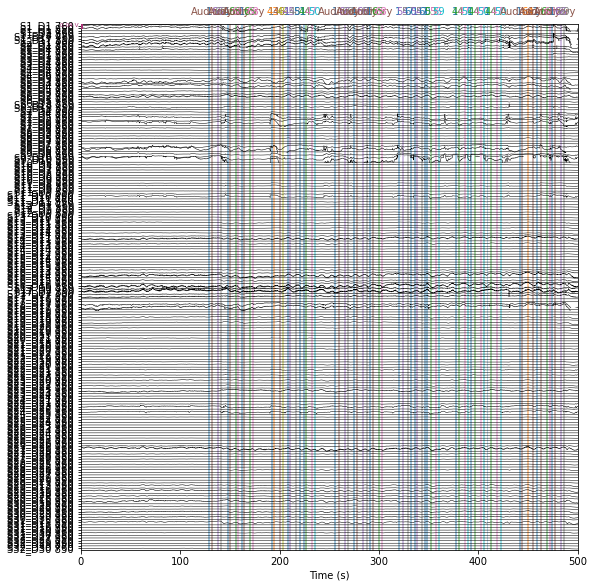

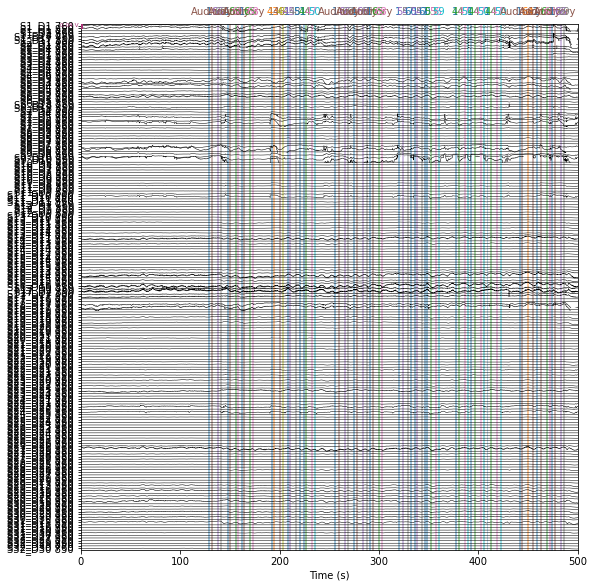

In [22]:
# Selecting channels appropriate for detected neural signals by picking channels that are not short
picks = mne.pick_types(raw.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(
    raw.info, picks=picks)
raw.pick(picks[dists > 0.01])
raw.plot(n_channels=len(raw.ch_names),
                   duration=500, show_scrollbars=False)

# this dosen't look as nice, because we have many channels compared to the MNE-python tutorial 

Reading 0 ... 8022  =      0.000 ...  2102.566 secs...


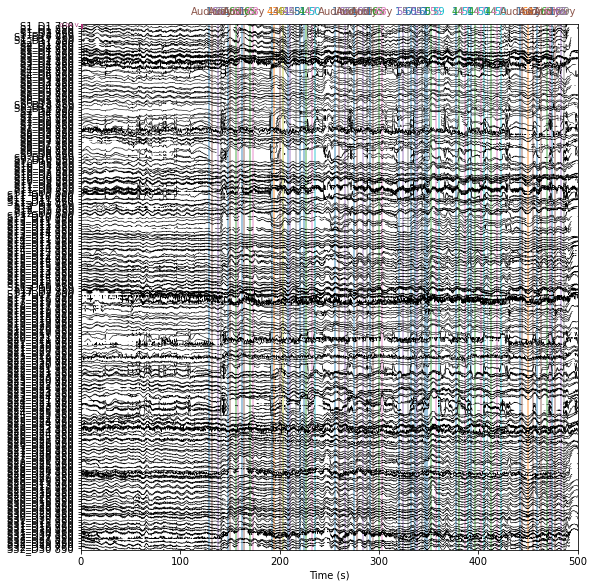

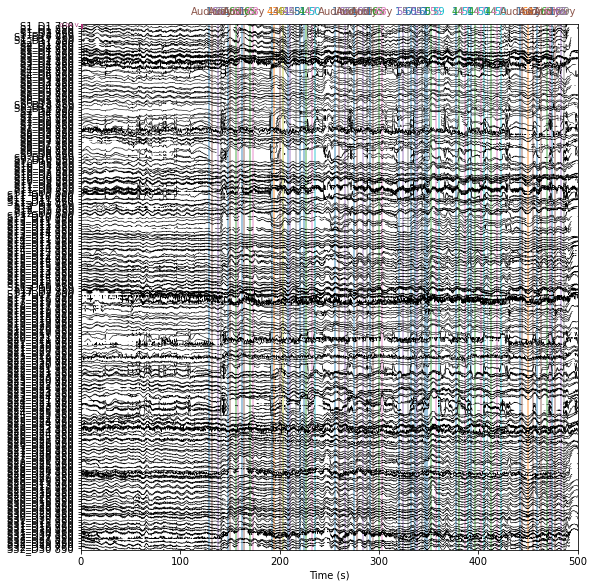

In [23]:
# Converting from raw intensity to optical density
raw_od = mne.preprocessing.nirs.optical_density(raw)
raw_od.plot(n_channels=len(raw_od.ch_names),
            duration=500, show_scrollbars=False)

Evaluating the quality of the data by use of scalp coupling index (SCI)

[Text(0.5, 0, 'Scalp Coupling Index'), Text(0, 0.5, 'Count'), (0.0, 1.0)]

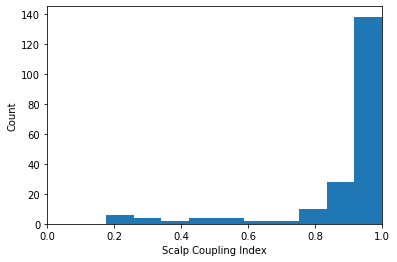

In [24]:
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax = plt.subplots()
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])

Here, we'll take a liberal approach and only mark channels with SCI <.2 as bad.

In [25]:
raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))

In [37]:
# get a list of which channels are bad
print(raw_od.info['bads'])  # print is not stricly necessary, but it won't print when I have another function in the block unless I write print

# count them
len(raw_od.info['bads'])

# 16 channels were bad

['S3_D4 760', 'S3_D4 850', 'S8_D3 760', 'S8_D3 850', 'S17_D19 760', 'S17_D19 850', 'S21_D18 760', 'S21_D18 850', 'S22_D19 760', 'S22_D19 850', 'S26_D24 760', 'S26_D24 850', 'S26_D26 760', 'S26_D26 850', 'S32_D27 760', 'S32_D27 850']


16

In [11]:
help(raw_od.info)

Help on Info in module mne.io.meas_info object:

class Info(builtins.dict, MontageMixin)
 |  Info(*args, **kwargs)
 |  
 |  Measurement information.
 |  
 |  This data structure behaves like a dictionary. It contains all metadata
 |  that is available for a recording. However, its keys are restricted to
 |  those provided by the
 |  `FIF format specification <https://github.com/mne-tools/fiff-constants>`__,
 |  so new entries should not be manually added.
 |  
 |  .. warning:: The only entries that should be manually changed by the user
 |               are ``info['bads']``, ``info['description']``,
 |               ``info['experimenter']`` and ``info['line_freq']``. All other
 |               entries should be considered read-only, though they can be
 |               modified by various MNE-Python functions or methods (which
 |               have safeguards to ensure all fields remain in sync).
 |  
 |  .. warning:: This class should not be instantiated directly. To create a
 |       

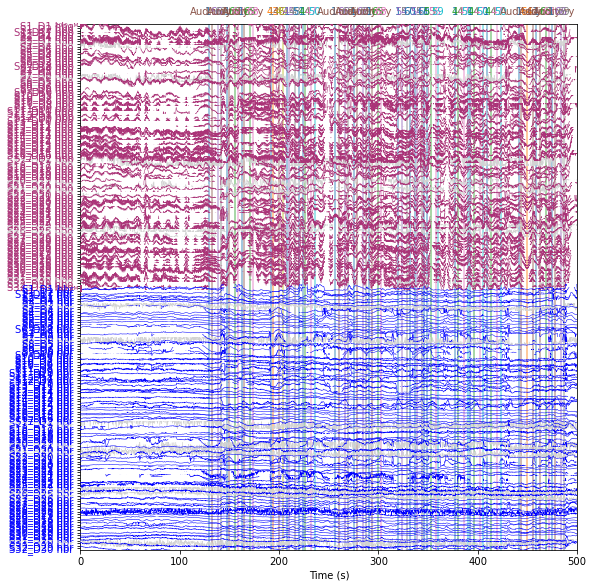

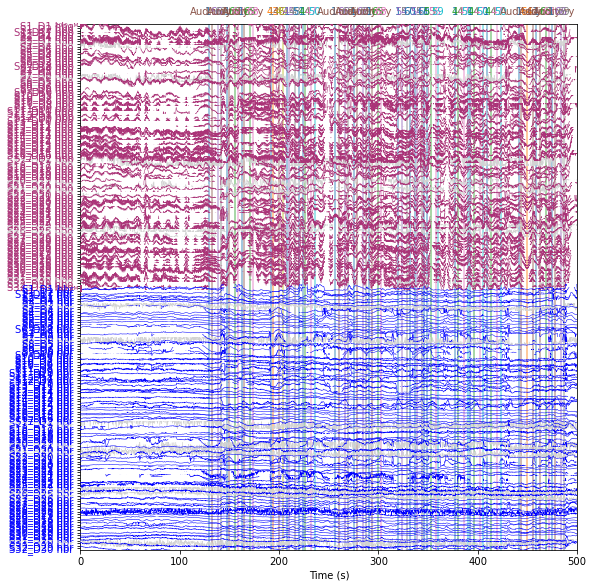

In [38]:
# Converting from optical density to haemeoglobin
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)
raw_haemo.plot(n_channels=len(raw_haemo.ch_names),
               duration=500, show_scrollbars=False)

Removing heart rate signal using a lowpass filter of .05. We use a high pass filter of .7 to remove 'slow drifts in the data'.



Effective window size : 536.781 (s)
Effective window size : 536.781 (s)


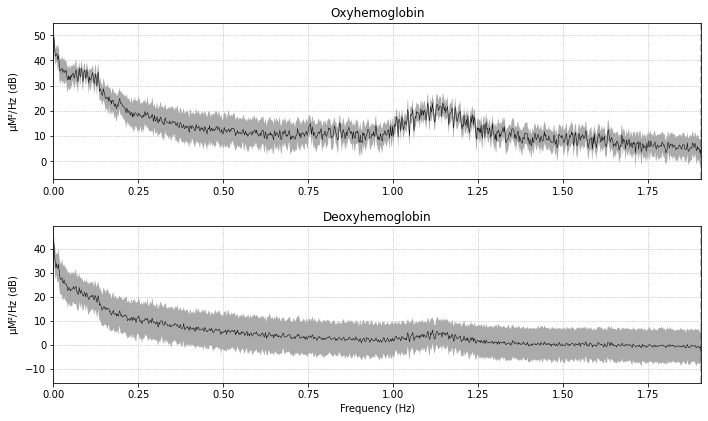

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 631 samples (165.385 sec)

Effective window size : 536.781 (s)
Effective window size : 536.781 (s)


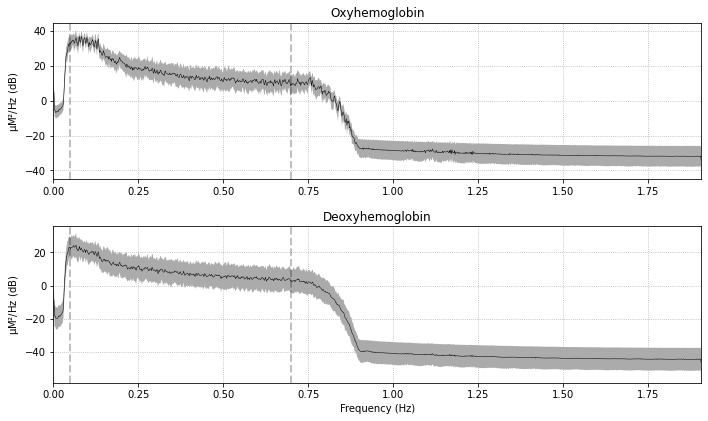

In [39]:
# plot before filtering
fig = raw_haemo.plot_psd(average=True)
fig.suptitle('Before filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)

# applying low- and highpass filters
raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
                             l_trans_bandwidth=0.02)

# plot after filtering
fig = raw_haemo.plot_psd(average=True)
fig.suptitle('After filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)

Now, it's epoching time. That is, we extract the epochs which are related to the experimental conditions (visual/auditory stim)

Used Annotations descriptions: ['1', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '64', '65', '66', '67', '68', '69', '73', '74', '75', '76', '77', '78', 'Auditory', 'Visual']


/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_6922/1189613423.py:3: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.


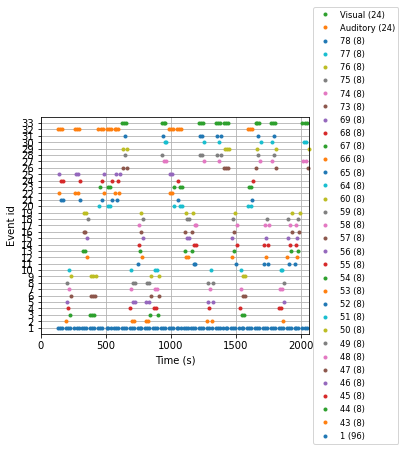

In [40]:
events, event_dict = mne.events_from_annotations(raw_haemo)

#plot
fig = mne.viz.plot_events(events, event_id=event_dict,
                          sfreq=raw_haemo.info['sfreq'])
fig.subplots_adjust(right=0.7)  # make room for the legend

It looks fine, I guess.

Next we define the range of our epochs, the rejection criteria, baseline correction, and extract the epochs. We visualise the log of which epochs were dropped (from tutorial).

Not setting metadata
Not setting metadata
384 matching events found
Setting baseline interval to [-2.0968, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 384 events and 36 original time points ...
    Rejecting  epoch based on HBO : ['S7_D6 hbo', 'S7_D8 hbo', 'S11_D9 hbo', 'S13_D10 hbo', 'S16_D15 hbo', 'S20_D21 hbo', 'S22_D21 hbo', 'S24_D21 hbo', 'S24_D23 hbo', 'S24_D25 hbo', 'S31_D15 hbo']
    Rejecting  epoch based on HBO : ['S7_D5 hbo', 'S7_D6 hbo', 'S7_D8 hbo', 'S9_D8 hbo', 'S11_D8 hbo', 'S11_D9 hbo', 'S11_D10 hbo', 'S13_D10 hbo', 'S16_D15 hbo', 'S20_D21 hbo', 'S22_D21 hbo', 'S22_D23 hbo', 'S24_D21 hbo', 'S24_D23 hbo', 'S24_D25 hbo', 'S31_D15 hbo']
    Rejecting  epoch based on HBO : ['S7_D6 hbo', 'S7_D8 hbo', 'S9_D8 hbo', 'S9_D10 hbo', 'S11_D8 hbo', 'S11_D9 hbo', 'S11_D10 hbo', 'S15_D12 hbo', 'S15_D15 hbo', 'S19_D18 hbo', 'S20_D21 hbo', 'S22_D21 hbo', 'S22_D23 hbo', 'S24_D21 hbo', 'S24_D23 hbo', 'S24_D25 hbo', 'S30_D28 hbo', 'S31_D

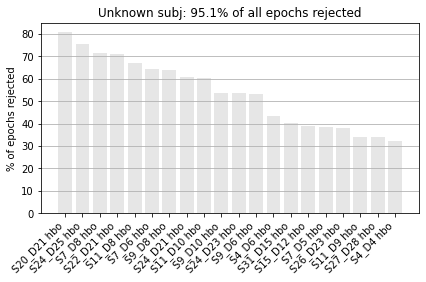

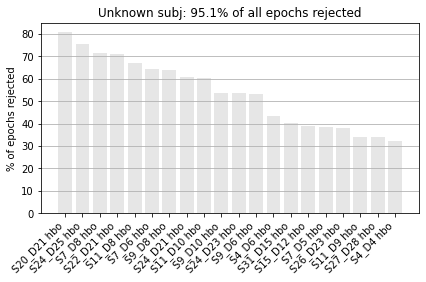

In [44]:
# signal which are unlikely large are removed
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -2, 7 #time

epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                    tmin=tmin, tmax=tmax,
                    reject=reject_criteria, reject_by_annotation=True,
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=None, verbose=True)
epochs.plot_drop_log()

This looks really bad... 95.1 % of epochs were rejected for this participant.

Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"


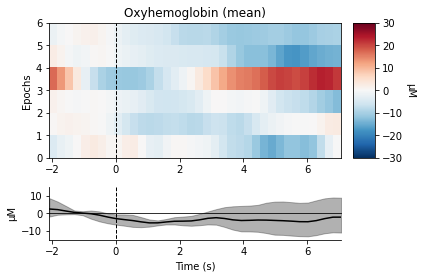

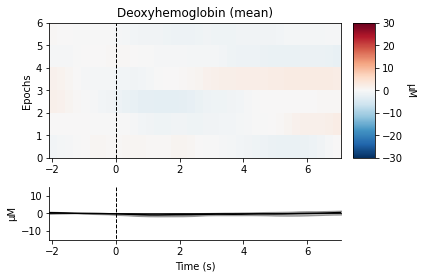

Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"


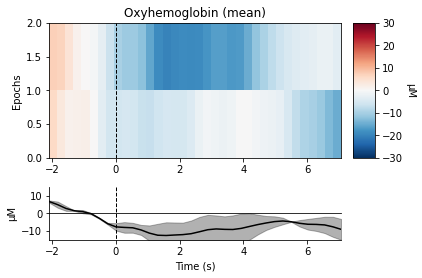

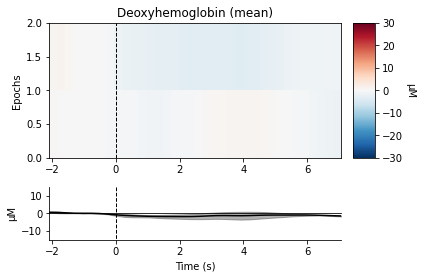

[<Figure size 432x288 with 3 Axes>, <Figure size 432x288 with 3 Axes>]

In [47]:
# viewing consistency of hemoglobin over trials

# visual 
epochs['Visual'].plot_image(combine='mean', vmin=-30, vmax=30,
                             ts_args=dict(ylim=dict(hbo=[-15, 15],
                                                    hbr=[-15, 15])))
# auditory
epochs['Auditory'].plot_image(combine='mean', vmin=-30, vmax=30,
                             ts_args=dict(ylim=dict(hbo=[-15, 15],
                                                    hbr=[-15, 15])))


Doesn't look too good..

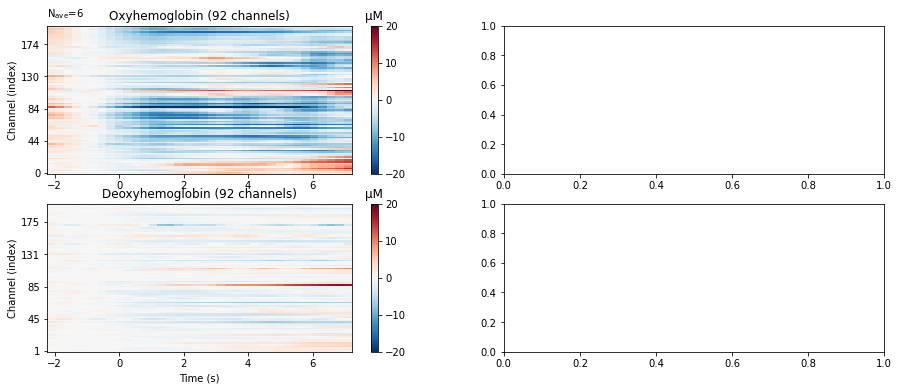

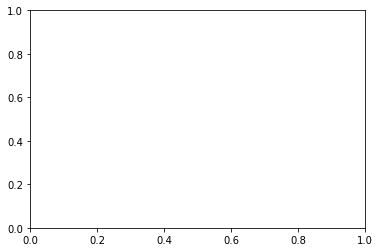

In [48]:
# consistency of responses across channels
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
clims = dict(hbo=[-20, 20], hbr=[-20, 20])
epochs['Visual'].average().plot_image(axes=axes[:, 0], clim=clims)
epochs['Auditory'].average().plot_image(axes=axes[:, 1], clim=clims)
for column, condition in enumerate(['Visual', 'Auditory']):
    for ax in axes[:, column]:
        ax.set_title('{}: {}'.format(condition, ax.get_title()))

I'm not sure how this is supposed to look like..

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


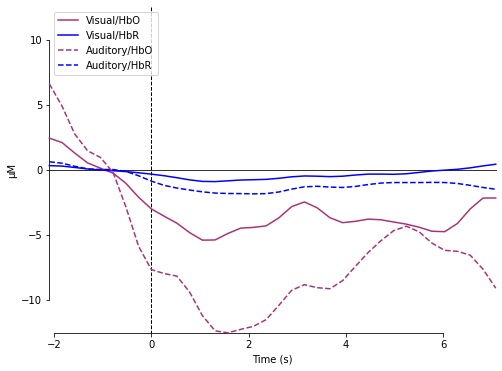

[<Figure size 576x432 with 1 Axes>]

In [51]:
evoked_dict = {'Visual/HbO': epochs['Visual'].average(picks='hbo'),
               'Visual/HbR': epochs['Visual'].average(picks='hbr'),
               'Auditory/HbO': epochs['Auditory'].average(picks='hbo'),
               'Auditory/HbR': epochs['Auditory'].average(picks='hbr')}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Auditory=dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                             colors=color_dict, styles=styles_dict)

Definitively not what it's supposed to look like. 

No projector specified for this dataset. Please consider the method self.add_proj.


ValueError: Times should be between -2.1 and 7.08.

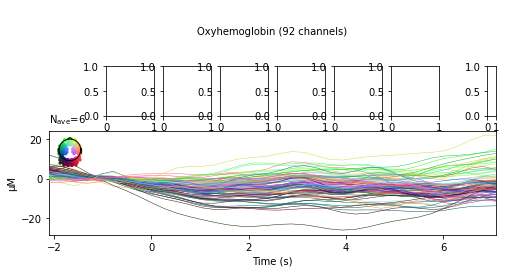

In [52]:
# Topographic representation of activity
times = np.arange(-3.5, 13.2, 3.0)
topomap_args = dict(extrapolate='local')
epochs['Visual'].average(picks='hbo').plot_joint(
    times=times, topomap_args=topomap_args)

Effective window size : 536.781 (s)


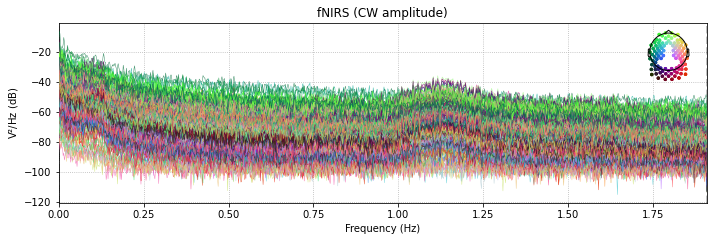

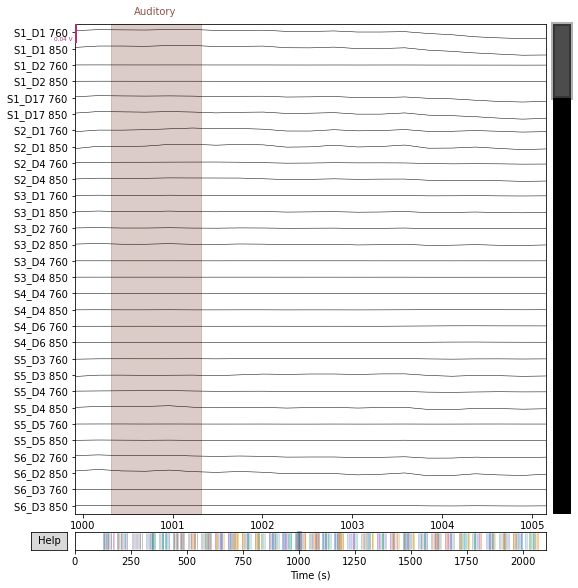

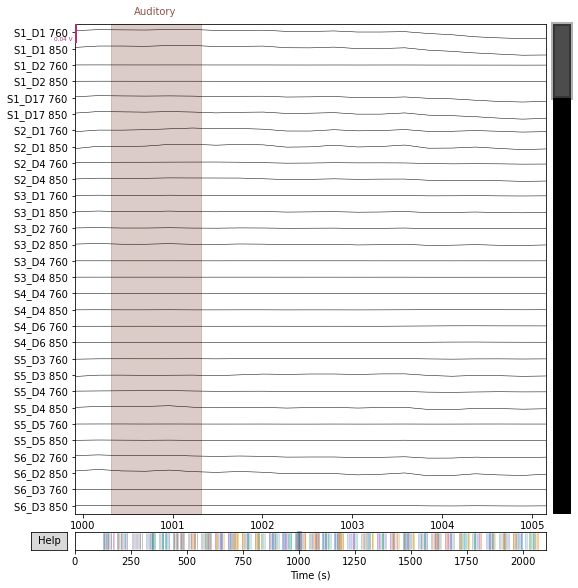

In [53]:
# voltage frequency plot ? heart rate is visible at about 1.1 Hz
raw.plot_psd()

# another plot 
raw.plot(duration=5, n_channels=30, start = 1000)

Brain plot

In [25]:
subjects_dir = op.join(mne.datasets.sample.data_path(), 'subjects')

brain = mne.viz.Brain(
    'fsaverage', subjects_dir= subjects_dir, background='w', cortex='0.5')
brain.add_sensors(
    raw_intensity.info, trans='fsaverage',
    fnirs=['channels', 'pairs', 'sources', 'detectors'])
brain.show_view(azimuth=20, elevation=60, distance=400)

/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_714/1677432030.py:3: DeprecationWarning: The Mayavi 3D backend is deprecated in 0.24 and will be removed in the next version of MNE-Python. Use the pyvistaqt or notebook backends instead


AttributeError: '_Renderer' object has no attribute '_window_close_connect'